# Bayesian approaches homework - 60 points total

## Part 1:  Bayesian Tomatoes (30 points)

In this part of the assignment, you'll implement the final part of a Naive Bayes classifier that performs sentiment analysis on sentences from movie reviews.  Upload and read the train.tsv file that contains sentences and phrases that have been rated 0 to 4 for sentiment ranging from very negative to very positive.  We'll only be working with the full sentences.

In [2]:
from google.colab import files

uploaded = files.upload() # upload train.tsv

Saving train.tsv to train.tsv


In [3]:
import nltk
nltk.download('punkt')  # Data for tokenization

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
with open('train.tsv', 'r') as textfile:
  ratings_data = textfile.read()
print(ratings_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from nltk.tokenize import word_tokenize

def tokenize(sentence):
    """ Returns list of tokens (strings) from the sentence.

    Sets to lowercase and runs NLTK tokenizer.

    Args:
        sentence (string):  the string to tokenize
    """
    return [t.lower() for t in word_tokenize(sentence)]

class ModelInfo:
    """ Contains all counts from the data necessary to do Naive Bayes.

    Attributes:
        word_counts (List[Dict[string,int]]):  counts of tokens, indexed by class
        sentiment_counts (List[int]):  counts of sentences with each sentiment
        total_words (List[int]):  counts of words in each sentiment
        total_examples (int):  total sentence count
    """

    def __init__(self):
        self.word_counts = [{}, {}, {}, {}, {}]
        self.sentiment_counts = [0, 0, 0, 0, 0]
        self.total_words = [0, 0, 0, 0, 0]
        self.total_examples = 0


    def update_word_counts(self, sentence, sentiment):
        """ Consume a sentence and update all counts.

        To "tokenize" the sentence we'll make use of NLTK, a widely-used Python natural language
        processing (NLP) library.  This will handle otherwise onerous tasks like separating periods
        from their attached words.  (Unless the periods are decimal points ... it's more complex
        than you might think.)  The result of tokenization is a list of individual strings that are
        words or their equivalent.

        Args:
            sentence (string):  The example sentence.
            sentiment (int):  The sentiment label.
        """

        # Get the relevant dicts for the sentiment
        s_word_counts = self.word_counts[sentiment]
        tokens = tokenize(sentence)
        for token in tokens:
            self.total_words[sentiment] += 1
            s_word_counts[token] = s_word_counts.get(token, 0) + 1

FIRST_SENTENCE_NUM = 1

def get_models(ratings_data):
    """Returns a model_info object, consuming a string for examples."""
    next_fresh = FIRST_SENTENCE_NUM
    info = ModelInfo()
    for line in ratings_data.splitlines():
        if line.startswith("---"):
            return info
        fields = line.split("\t")
        try:
            sentence_num = int(fields[1])
            if sentence_num <= next_fresh:
                continue
            next_fresh += 1
            sentiment = int(fields[3])
            info.sentiment_counts[sentiment] += 1
            info.total_examples += 1
            info.update_word_counts(fields[2], sentiment)
        except ValueError:
            # Some kind of bad input?  Unlikely with our provided data
            continue
    return info

model_info = get_models(ratings_data)

**(P1, 30 points)** Complete naive_bayes_classify(), below.  It should take a ModelInfo object and use the counts stored therein to give the most likely class according to a Naive Bayes calculation, and the log likelihood of that class.  For priors on the sentiment, use the actual frequencies with which each sentiment is used.  Notice that there are 5 different classes to compare.  Use the OUT_OF_VOCAB_PROB constant for any tokens that haven't been seen for a particular sentiment in the data.

In [ ]:
import math
import operator
from functools import reduce
OUT_OF_VOCAB_PROB = 0.0000000001

def naive_bayes_classify(info, sentence):
    """ Use a Naive Bayes model to return sentence's most likely classification and the log prob.

    Args:
        info (ModelInfo):  a ModelInfo containing the counts from the training data
        sentence (string):  the test sentence to classify

    Returns:
        int for the best sentiment
        float for the best log probability (unscaled, just log(prior * product of cond. probs))
    """

    #P(A|B) = P(B|A)P(A) / P(B)
    #for log
    #logP(sentiment=k) + sum logP(wordi(from sentence)|sentiment = k)
    #most positive log is the best_class

    tokens = tokenize(sentence)

    sentimentProb = [info.sentiment_counts[i]/info.total_examples for i in range(5)]

    wordProb = (1/len(tokens))

    def prod(factors):
        return reduce(operator.mul, factors, 1)

    final = []

    def probWordGivenSentiment(token, sentiment):
      if token in info.word_counts[sentiment]:
        tokenIndex = list(info.word_counts[sentiment].keys()).index(token)
        tokenCount =  list(info.word_counts[sentiment].values())[tokenIndex]
        return tokenCount/info.total_words[sentiment]
      else:
        return OUT_OF_VOCAB_PROB

    for i in range(5):
      likelihoods = []
      for j in tokens:
        likelihoods.append(probWordGivenSentiment(j, i))

      product = prod(likelihoods)

      final.append( math.log(sentimentProb[i]) + math.log(product))
    
    best_class = final.index(max(final))
    best_log_prob = max(final)

    return best_class, best_log_prob
    

In [ ]:
# Tests
print(naive_bayes_classify(model_info, "I hate this movie")) # Should return 0, -25.9

(0, -25.947997071867018)


In [ ]:
print(naive_bayes_classify(model_info, "A joyous romp"))    # Should return 4, -22.9

(4, -22.9049498861873)


In [ ]:
print(naive_bayes_classify(model_info, "notaword")) # Should return 3, -24.3

(3, -24.32724312507062)


## Part 2: Bayesian Networks and Covid Diagnosis (30 points)





Here, we'll implement some reasoning around a Bayesian network.  Rather than implement the full functionality of a Bayesian network, being able to supply any subset of the nodes as evidence and querying any of the other variables, we'll only allow some of the evidence to be missing, and we'll always query for the same unknown:  does this person have Covid?

The following code box includes rates of infection for a Covid-infected group and a control group (for example, 41 subjects out of 120 who had Covid showed loss of taste; 7 out of 120 who did not have Covid also reported this).  It also gives a simulated function for Pr(Covid|MinutesNearKnownCase).

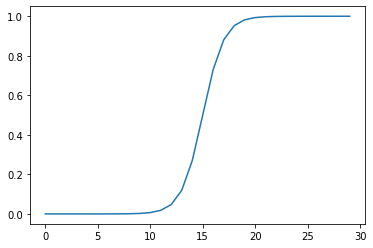

In [ ]:
# Odds of symptoms from:  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7584484/ (Table 1)
# Originally, these were all given fever, cough, and/or suspected contact -
# but you don't need to model that in this exercise.
# Pos are the numbers for those who eventually tested positive (symptom/total),
# Neg are for those who tested negative.
#                    Pos          Neg
# Loss of taste:    41/120        7/120
# Chills/sweats:    34/120        20/120
# Loss of smell:    36/120        8/120

# One continuous predictor:  minutes spent within 6 feet of an infected person.
# We'll model Pr(infection | minutes) with a sigmoid/logistic function that hits the 0.5
# mark at 15 minutes.  (This is not a real model, though 15 minutes has been
# singled out as a dangerous threshold.)

import numpy as np

# This model has a little too much certainty to be realistic -
# take it with a grain of salt!
def p_infect_given_minutes(minutes):
  return 1 / (1 + np.exp(-minutes+15))

import matplotlib.pyplot as plt

x = range(30)
samples = [p_infect_given_minutes(i) for i in range(30)]

plt.plot(x, samples)

The Bayesian network we want you to reason about has the following structure, reflecting the causal connections between these variables.

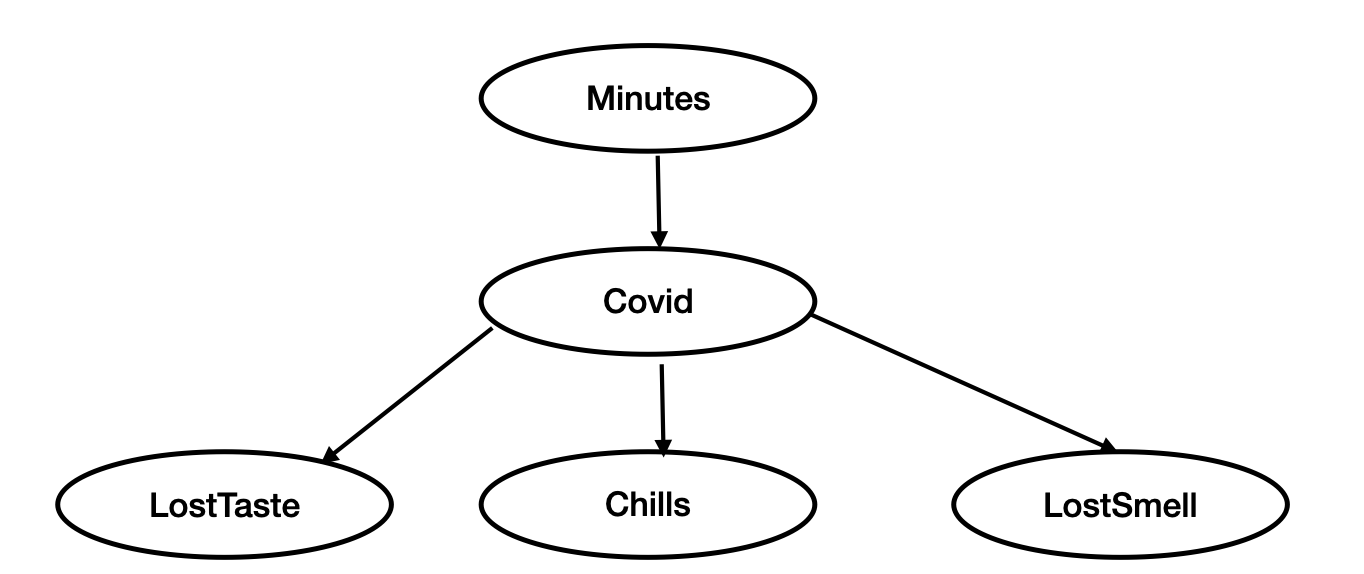

**P2 (26 points):** Now you will write code that, given the number of minutes of proximity to an infected person and a list of Boolean values for symptoms, calculates the probability the subject has Covid.  The minutes are always supplied, but the list could be shorter than three elements, in which case we assume the information is supplied in the order *LostTaste, Chills, LostSmell*.  For example, give_covid_prob(10,[True, False]) means that the subject was near an exposed person for 10 minutes, they report loss of taste, they had no chills, and we don't know about their sense of smell.

There will be some parts of this Bayesian network model, like P(minutes), that won't figure into the code, and that is okay.  (In fact, this will look remarkably similar to Naive Bayes, since we're not using a big network for the model, and that is also okay.)

Be careful about how you think about the probabilities.  If you're not computing 1-p for some probabilities p, you've probably messed up.  Also, notice that you don't really need to sum over the possibilities for unobserved symptoms; doing so would just calculate things like what_you_had_before * p + what_you_had_before * (1-p) = what_you_had_before.

In [ ]:
# Minutes is the number of minutes that the subject has spent close to someone
# with Covid-19.
# Symptoms is a list of True or False for loss of taste, chills, loss of smell,
# in that order. If the list is short, the information is missing.
# (The list could be empty.)
# Return the probability of Covid given the information we have.

# These are for indexing into the list
#P(Cov|S1,S2,S3,Minutes) = P(Covid|Minutes)P(S1|Covid)P(S2|Covid)P(S3|Covid)
LOST_TASTE = 0
CHILLS = 1
LOST_SMELL = 2

def give_covid_prob(minutes, symptoms):
  symptomProb = [41/120, 34/120, 36/120]
  antiSymptomProb = [7/120, 20/120, 8/120]
  timeInfect = p_infect_given_minutes(minutes)
  antiTimeInfect = p_infect_given_minutes(30-minutes)

  covprob = 0
  nocovprob = 0

  if len(symptoms) == 0:
    return timeInfect
  else:
    case = len(symptoms)
    if case >= 1:
      if symptoms[0] == True:
        covprob += timeInfect * symptomProb[LOST_TASTE]
        nocovprob += antiTimeInfect * antiSymptomProb[LOST_TASTE]
      elif symptoms[0] == False:
        covprob += timeInfect * (1-symptomProb[LOST_TASTE])
        nocovprob += antiTimeInfect * (1-antiSymptomProb[LOST_TASTE])
    if case >= 2:
      if symptoms[1] == True:
        covprob *= symptomProb[CHILLS]
        nocovprob *= antiSymptomProb[CHILLS]
      elif symptoms[1] == False:
        covprob *= (1-symptomProb[CHILLS])
        nocovprob *= (1-antiSymptomProb[CHILLS])
    if case >= 3:
      if symptoms[2] == True:
        covprob *= symptomProb[LOST_SMELL]
        nocovprob *= antiSymptomProb[LOST_SMELL]
      elif symptoms[2] == False:
        covprob *= (1-symptomProb[LOST_SMELL])
        nocovprob *= (1-antiSymptomProb[LOST_SMELL])

    covid_prob_final = covprob/(covprob + nocovprob)
  return covid_prob_final
  

In [ ]:
give_covid_prob(15,[True, True, True]) # Expect 0.978

0.9781693435209731

In [ ]:
give_covid_prob(2, [True, True, False]) # Expect 1.69 # 10^-5

1.6879532183717405e-05

In [ ]:
give_covid_prob(10, [True]) # Expect 0.0380

0.037966755640837326

In [ ]:
give_covid_prob(25, []) # Expect 0.99995

0.9999546021312976

**P3 (4 points):** Suppose we wanted to use these probabilities to infer, from the symptoms, the distribution on the subject's amount of time spent with someone who had Covid.  What additional information would we need, and why do we need it?

**You would need to know if the sympoms are independent of each other or not. Since if the original bayesian contained dependence relations between the symptoms they would not be properly accounted for in the reversed Bayesian graph.**

****When you're done, use "File->Download .ipynb" and upload your .ipynb file to Blackboard, along with a PDF version (File->Print->Save as PDF) of your assignment.**